# Data Loading

In [1]:
pip install pandas

  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

df_actor_pairs = pd.read_csv('actor_movies.csv')
df_lead_roles = pd.read_csv('lead_roles.csv')
df_actor_pairs.head()

,Actor 1,Actor ID 1,Actor 2,Actor ID 2,Movie ID,Movie Title,Year,Runtime Minutes,Genres
0,Lauren Bacall,nm0000002,Laura Bailey,nm0047362,tt0117057,The Mirror Has Two Faces,1996,126,"Comedy,Drama,Romance"
1,Lauren Bacall,nm0000002,William Cain,nm0128972,tt0117057,The Mirror Has Two Faces,1996,126,"Comedy,Drama,Romance"
2,Lauren Bacall,nm0000002,Rudy Ruggiero,nm0173979,tt0117057,The Mirror Has Two Faces,1996,126,"Comedy,Drama,Romance"
3,Lauren Bacall,nm0000002,Cindy Guyer,nm0349875,tt0117057,The Mirror Has Two Faces,1996,126,"Comedy,Drama,Romance"
4,Lauren Bacall,nm0000002,Anne O'Sullivan,nm0642721,tt0117057,The Mirror Has Two Faces,1996,126,"Comedy,Drama,Romance"


# Data Processing

In [4]:
df_actor_pairs['Sorted IDs'] = df_actor_pairs.apply(lambda row: tuple(sorted((row['Actor ID 1'],
                                                                              row['Actor ID 2'])))
                                                                              + (row['Movie ID'],), axis=1)
df_actor_pairs = df_actor_pairs.drop_duplicates(subset=['Sorted IDs'], keep='first')
df_actor_pairs = df_actor_pairs.drop(columns=['Sorted IDs'])

In [5]:
pair_counts = df_actor_pairs.groupby(['Actor ID 1', 'Actor ID 2']).size().reset_index(name='appearances')

filtered_pairs = pair_counts[pair_counts['appearances'] > 1]

filtered_pairs.head()

,Actor ID 1,Actor ID 2,appearances
52,nm0000004,nm0413147,2
158,nm0000045,nm0157300,2
163,nm0000045,nm0398935,2
168,nm0000045,nm0490492,2
169,nm0000045,nm0498044,2


In [6]:
actors = pd.concat([filtered_pairs['Actor ID 1'], filtered_pairs['Actor ID 2']]).unique()

# Network Construction

In [7]:
import networkx as nx

G = nx.Graph()

G.add_nodes_from(actors)

for index, row in filtered_pairs.iterrows():
  G.add_edge(row['Actor ID 1'], row['Actor ID 2'], weight=row['appearances'])

print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")


Number of Nodes: 6210
Number of Edges: 8240


# Identifying Key Influencers in Actor Network

In [12]:
from collections import Counter

degree_centrality = nx.degree_centrality(G)

top_10_actors = sorted(degree_centrality.items(), key=lambda kv: kv[1], reverse=True)[:10]

for actor_id in top_10_actors:
  actor = df_actor_pairs[(df_actor_pairs['Actor ID 1'] == actor_id[0])]
  print(f"ID: {actor_id[0]}\nName: {actor['Actor 1'].unique()[0]}\nScore: {actor_id[1]}\n")
  genres = Counter(actor['Genres'].str.cat(sep=',').split(',')).most_common(5)
  for genre in genres:
    print(f"- {genre[0]}")
  print()

ID: nm1116175
Name: Katie Jackson
Score: 0.005475922048639072

- Adventure
- Fantasy
- Action
- Drama

ID: nm0000276
Name: Sean Astin
Score: 0.005314865517796747

- Adventure
- Action
- Drama
- Comedy
- Family

ID: nm0000704
Name: Elijah Wood
Score: 0.005314865517796747

- Drama
- Action
- Adventure
- Romance
- Sci-Fi

ID: nm0005212
Name: Ian McKellen
Score: 0.005314865517796747

- Drama
- Action
- Adventure
- Biography

ID: nm0089217
Name: Orlando Bloom
Score: 0.005314865517796747

- Action
- Adventure
- Drama
- Fantasy

ID: nm0101710
Name: Billy Boyd
Score: 0.005314865517796747

- Action
- Adventure
- Drama

ID: nm0413309
Name: Billy Jackson
Score: 0.005314865517796747

- Drama
- Action
- Adventure
- Fantasy
- Thriller

ID: nm0597480
Name: Dominic Monaghan
Score: 0.005314865517796747

- Action
- Adventure
- Drama

ID: nm0721615
Name: Don Reynolds
Score: 0.005314865517796747

- Action
- Adventure
- Drama

ID: nm0722636
Name: John Rhys-Davies
Score: 0.005314865517796747

- Action
- Adv

In [13]:
closeness_centrality = nx.closeness_centrality(G)
pagerank = nx.pagerank(G, alpha=0.9)

In [14]:
degree_centrality_df = pd.DataFrame(degree_centrality.items(),
                                    columns=['Actor ID 1', 'Degree Centrality'])
closeness_centrality_df = pd.DataFrame(closeness_centrality.items(),
                                    columns=['Actor ID 1', 'Closeness Centrality'])
pagerank_df = pd.DataFrame(pagerank.items(),
                                    columns=['Actor ID 1', 'Page Rank'])

In [15]:
from scipy.stats import pearsonr

merged_df1 = pd.merge(df_actor_pairs[["Actor ID 1", "Movie ID"]],
                     df_lead_roles, left_on='Movie ID', right_on='movie', how='inner')
merged_df2 = pd.merge(df_actor_pairs[["Actor ID 2", "Movie ID"]],
                     df_lead_roles, left_on='Movie ID', right_on='movie', how='inner')

merged_df2.rename(columns={'Actor ID 2': 'Actor ID 1'}, inplace=True)

merged_df = pd.concat([merged_df1, merged_df2])

merged_df['Lead Role'] = (merged_df['Actor ID 1'] == merged_df['actor']).astype(int)
merged_df = merged_df[['Actor ID 1', 'Movie ID', 'Lead Role']].drop_duplicates()

merged_df = pd.merge(merged_df, degree_centrality_df, on='Actor ID 1', how='inner')
merged_df = pd.merge(merged_df, closeness_centrality_df, on='Actor ID 1', how='inner')
merged_df = pd.merge(merged_df, pagerank_df, on='Actor ID 1', how='inner')
df = merged_df.sort_values(by=['Actor ID 1', 'Movie ID', 'Lead Role'], ascending=[True, True, False])
df = df.drop_duplicates(subset=['Actor ID 1', 'Movie ID'], keep='first')

df.head()

,Actor ID 1,Movie ID,Lead Role,Degree Centrality,Closeness Centrality,Page Rank
4,nm0000004,tt0077975,1,0.000161,0.000161,0.000161
2,nm0000004,tt0078723,1,0.000161,0.000161,0.000161
0,nm0000004,tt0080455,1,0.000161,0.000161,0.000161
6,nm0000045,tt0067824,1,0.000966,0.000966,0.000161
8,nm0000045,tt0068767,1,0.000966,0.000966,0.000161


In [16]:
correlation_coefficient, p_value = pearsonr(df['Lead Role'], df['Degree Centrality'])
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: -0.019065838710045326
P-value: 0.01987475000084282


# Analyzing Actor Co-starring communities

In [17]:
pip install python-louvain

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9473 sha256=ee15eabfdfe55f9ed373d8a7f6403a5e0a3b2c9bc6265a0b8e7b577ce5c51d84
  Stored in directory: c:\users\julia\appdata\local\pip\cache\wheels\40\f1\e3\485b698c520fa0baee1d07897abc7b8d6479b7d199ce96f4af
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


In [19]:
from community import community_louvain as louvain
from collections import defaultdict

partition = louvain.best_partition(G, random_state=11)

largest_community = max(set(partition.values()), key=list(partition.values()).count)

community_actors = [actor for actor in partition if partition[actor] == largest_community]

movie_info = defaultdict(lambda: {'actors': [], 'title': None})

for index, row in df.iterrows():
    actor = row['Actor ID 1']
    movie_id = row['Movie ID']

    if actor in community_actors:
        movie_info[movie_id]['actors'].extend(actor)
        movie_info[movie_id]['title'] = df_actor_pairs[df_actor_pairs['Movie ID'] == movie_id]['Movie Title'].iloc[0]

print(f"Largest Community: {largest_community}")
print("Actors:")
for actor_id in community_actors:
    actor = df_actor_pairs[(df_actor_pairs['Actor ID 1'] == actor_id)]['Actor 1']
    if not actor.empty:
        print('{0:5} {1}'.format(actor_id, actor.iloc[0]))
    else:
        actor = df_actor_pairs[df_actor_pairs['Actor ID 2'] == actor_id]['Actor 2']
        if not actor.empty:
          print('{0:5} {1}'.format(actor_id, actor.iloc[0]))
print("\nMovies:")
for movie_id, info in movie_info.items():
    print('{0:5} {1:50} {2:5}'.format(movie_id, info['title'], len(info['actors'])))

Largest Community: 46
Actors:
nm0000278 Pernilla August
nm0000355 Anthony Daniels
nm0000402 Carrie Fisher
nm0001190 David Prowse
nm0001385 Eric Idle
nm0001519 Ian McDiarmid
nm0001589 Michael Palin
nm0001850 Billy Dee Williams
nm0003296 C. Andrew Nelson
nm0023030 Melissa Altro
nm0029025 David Andriole
nm0048652 Kenny Baker
nm0050514 Michael Henbury Ballan
nm0054929 Ken Barker
nm0063027 Terence Bayler
nm0078886 Ahmed Best
nm0090124 Bruce Boa
nm0102704 Peter Brace
nm0120116 Jeremy Bulloch
nm0123214 Peter Burroughs
nm0159789 Hayden Christensen
nm0171829 Kenneth Colley
nm0174337 Tim Condren
nm0203882 Oliver Ford Davies
nm0212600 Derek Deadman
nm0222318 Myrtle Devenish
nm0225329 Joanna Dickens
nm0228915 Malcolm Dixon
nm0230301 Mark Dodson
nm0249507 Mike Edmonds
nm0284496 Phil Fondacaro
nm0315557 John Ghavan
nm0349822 Jennifer Guy
nm0376405 Don Henderson
nm0408017 Grant Imahara
nm0409205 Harold Innocent
nm0429104 Richard Jones
nm0493200 Denis Lawson
nm0507270 Howard Lew Lewis
nm0562679 Peter 

In [20]:
community_degree_centrality = {}
for community_id in set(partition.values()):
    community_actors = [actor for actor in partition if partition[actor] == community_id]
    sum_degree_centrality = 0
    count = 0
    for actor in community_actors:
      sum_degree_centrality += df[df['Actor ID 1'] == actor]['Degree Centrality'].iloc[0]
      count += 1
    avg_degree_centrality = sum_degree_centrality / count
    community_degree_centrality[community_id] = avg_degree_centrality

highest_centrality_community = max(community_degree_centrality, key=community_degree_centrality.get)

community_actors = [actor for actor, community in partition.items() if community == highest_centrality_community]
community_movies = set()

movie_info = defaultdict(lambda: {'actors': [], 'title': None})

for index, row in df.iterrows():
    actor = row['Actor ID 1']
    movie_id = row['Movie ID']

    if actor in community_actors:
        movie_info[movie_id]['actors'].extend(actor)
        movie_info[movie_id]['title'] = df_actor_pairs[df_actor_pairs['Movie ID'] == movie_id]['Movie Title'].iloc[0]

prevalent_movies = dict(sorted(movie_info.items(), key=lambda item: len(item[1]['actors']), reverse=True)[:5])

In [22]:
print(f"Highest Average Degree Centrality: {community_degree_centrality[highest_centrality_community]}")
print(f"Community with highest average degree centrality:")
for actor_id in community_actors:
    actor = df_actor_pairs[(df_actor_pairs['Actor ID 1'] == actor_id)]['Actor 1']
    if not actor.empty:
        print('{0:5} {1}'.format(actor_id, actor.iloc[0]))
    else:
        actor = df_actor_pairs[df_actor_pairs['Actor ID 2'] == actor_id]['Actor 2']
        if not actor.empty:
          print('{0:5} {1}'.format(actor_id, actor.iloc[0]))
print("Prevalent Movies:")
for movie_id, count in prevalent_movies.items():
    movie_title = df_actor_pairs[df_actor_pairs['Movie ID'] == movie_id]['Movie Title'].iloc[0]
    print(f"- {movie_title} (appeared {len(count['actors'])} times)")

Highest Average Degree Centrality: 0.003319335818579638
Community with highest average degree centrality:
nm0000239 Liv Tyler
nm0000276 Sean Astin
nm0000293 Sean Bean
nm0000453 Ian Holm
nm0000489 Christopher Lee
nm0000704 Elijah Wood
nm0001557 Viggo Mortensen
nm0001584 Miranda Otto
nm0005212 Ian McKellen
nm0032370 Noel Appleby
nm0045324 John Bach
nm0089217 Orlando Bloom
nm0101710 Billy Boyd
nm0112400 Jed Brophy
nm0122591 Bob Burns
nm0132426 Eddie Campbell
nm0384060 Bernard Hill
nm0394126 Bruce Hopkins
nm0397102 Alan Howard
nm0413309 Billy Jackson
nm0538692 Lawrence Makoare
nm0572867 Sarah McLeod
nm0597480 Dominic Monaghan
nm0633604 John Noble
nm0662164 Craig Parker
nm0680273 Bruce Phillips
nm0689692 Robert Pollock
nm0721615 Don Reynolds
nm0722636 John Rhys-Davies
nm0728119 Todd Rippon
nm0881631 Karl Urban
nm0881831 Stephen Ure
nm0915989 Hugo Weaving
nm0920992 David Wenham
nm1115856 Phil Grieve
nm1116175 Katie Jackson
nm1401687 Ben Britton
nm0838605 John Sumner
nm0236911 Glen Drake
nm04

# Central Actors in Genre Networks

In [23]:
keys = ['Action','Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Fantasy',
'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
graphs_dict = {}
for key in keys:
  graphs_dict[key] = nx.Graph()
  graphs_dict[key].add_nodes_from(actors)

actor_pair_genres = defaultdict(list)
for _, row in df_actor_pairs.iterrows():
    actor_pair = tuple((row['Actor ID 1'], row['Actor ID 2']))
    actor_pair_genres[actor_pair].extend(row['Genres'].split(','))

for index, row in filtered_pairs.iterrows():
  actor_pair = tuple((row['Actor ID 1'], row['Actor ID 2']))
  genres = actor_pair_genres[actor_pair]
  for key in genres:
    if key in keys:
     graphs_dict[key].add_edge(row['Actor ID 1'], row['Actor ID 2'], weight=row['appearances'])
for key in keys:
  isolated_nodes = list(nx.isolates(graphs_dict[key]))
  graphs_dict[key].remove_nodes_from(isolated_nodes)

In [25]:
top_10_actors_by_genre = {}

for genre, graph in graphs_dict.items():
    if graph.number_of_nodes() > 0:
        degree_centrality = nx.degree_centrality(graph)
        top_10 = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]
        top_10_actors_by_genre[genre] = top_10
    else:
        print(f"Genre '{genre}' graph is empty.")

for genre, top_actors in top_10_actors_by_genre.items():
    print(f"\n{genre}:")
    for actor_id, centrality in top_actors:
        actor_name = df_actor_pairs[df_actor_pairs['Actor ID 1'] == actor_id]['Actor 1'].iloc[0]
        print('- {0:5} {1}'.format(actor_id, actor_name))


Action:
- nm1116175 Katie Jackson
- nm0000276 Sean Astin
- nm0000704 Elijah Wood
- nm0005212 Ian McKellen
- nm0089217 Orlando Bloom
- nm0101710 Billy Boyd
- nm0413309 Billy Jackson
- nm0597480 Dominic Monaghan
- nm0721615 Don Reynolds
- nm0722636 John Rhys-Davies

Adventure:
- nm1116175 Katie Jackson
- nm0000276 Sean Astin
- nm0000704 Elijah Wood
- nm0005212 Ian McKellen
- nm0089217 Orlando Bloom
- nm0101710 Billy Boyd
- nm0413309 Billy Jackson
- nm0597480 Dominic Monaghan
- nm0721615 Don Reynolds
- nm0722636 John Rhys-Davies

Animation:
- nm1236503 Z. Charles Bolton
- nm1267353 Darrell Waltrip
- nm0909274 Michael Wallis
- nm0038290 Yôko Asagami
- nm0386380 Taichirô Hirokawa
- nm0454083 Akira Kimura
- nm0620138 Shûsei Nakamura
- nm0623214 Gorô Naya
- nm0866753 Kei Tomiyama
- nm0946597 Yoshito Yasuhara

Comedy:
- nm0919169 Shaun Weiss
- nm1005785 Gwenda Perez
- nm0019783 Caner Alkaya
- nm0230596 Matt Doherty
- nm0489364 Vincent LaRusso
- nm0746626 Cassie Rowell
- nm0869290 Erdal Tosun


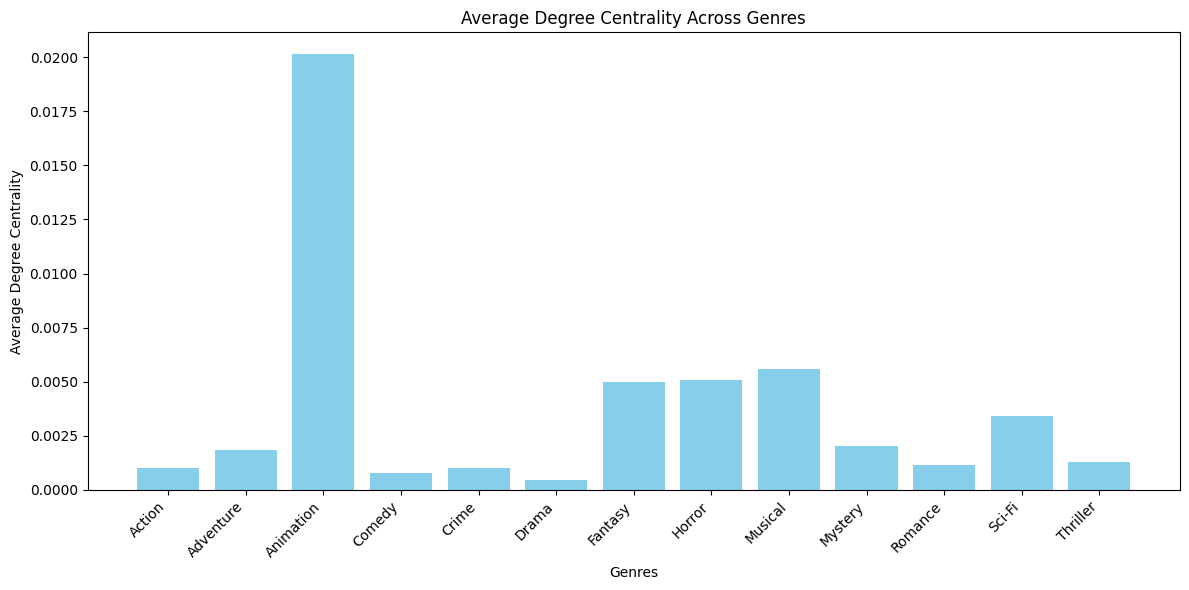

Genres ranked by average centrality:
- Animation: 0.020134228187919465
- Musical: 0.0056103501976600256
- Horror: 0.005083088954056695
- Fantasy: 0.004990974987823396
- Sci-Fi: 0.0034200107804687645
- Mystery: 0.002042610404385148
- Adventure: 0.0018564460428027662
- Thriller: 0.0012713007942015575
- Romance: 0.001146131805157593
- Action: 0.0010062811977798196
- Crime: 0.001003976092404592
- Comedy: 0.0007844032355937583
- Drama: 0.0004818972349530589


In [26]:
import matplotlib.pyplot as plt
import numpy as np

avg_centralities = {}
for genre, graph in graphs_dict.items():
    if graph.number_of_nodes() > 0:
        degree_centrality = nx.degree_centrality(graph)
        avg_centralities[genre] = np.mean(list(degree_centrality.values()))
    else:
        print(f"Genre '{genre}' graph is empty.")

genres = list(avg_centralities.keys())
centralities = list(avg_centralities.values())


plt.figure(figsize=(12, 6))
plt.bar(genres, centralities, color='skyblue')
plt.xlabel("Genres")
plt.ylabel("Average Degree Centrality")
plt.title("Average Degree Centrality Across Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

sorted_centralities = sorted(avg_centralities.items(), key=lambda x: x[1], reverse=True)

print("Genres ranked by average centrality:")
for genre, centrality in sorted_centralities:
    print(f"- {genre}: {centrality}")